In [1]:
import os
import glob
import time
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
import seaborn as sns

In [2]:
def butter_bandpass_filter(data, lowcut=25.0, highcut=400.0, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def get_binary_label(fname):
    fname = fname.lower()
    if "normal" in fname:
        return 0  # Normal
    elif any(x in fname for x in ["murmur", "artifact", "extrahls"]):
        return 1  # Abnormal
    else:
        return None

def extract_mfcc(cycle, sr, n_mfcc=13, max_len=260):
    mfcc = librosa.feature.mfcc(y=cycle.astype(np.float32), sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=128)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

In [3]:
# Load and Process Data
base_path = "/kaggle/input/heartbeat-sounds"
data_dirs = [os.path.join(base_path, "set_a"), os.path.join(base_path, "set_b")]
all_files = [file for folder in data_dirs for file in glob.glob(os.path.join(folder, "*.wav"))]

X_features = []
y_labels = []

for file_path in all_files:
    audio, sr = librosa.load(file_path, sr=None)
    if sr != 1000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=1000)
        sr = 1000

    audio = audio / np.max(np.abs(audio))
    filtered_audio = butter_bandpass_filter(audio, fs=sr)
    envelope = np.abs(hilbert(filtered_audio))
    peaks, _ = find_peaks(envelope, distance=int(0.4 * sr), height=np.mean(envelope) * 1.2)

    cardiac_cycles = []
    if len(peaks) >= 3:
        for i in range(len(peaks) - 2):
            start, end = peaks[i], peaks[i + 2]
            if end > start:
                cycle = filtered_audio[start:end]
                cardiac_cycles.append(cycle)

    label = get_binary_label(file_path)
    if label is not None:
        for cycle in cardiac_cycles:
            mfcc = extract_mfcc(cycle, sr)
            X_features.append(mfcc.flatten())
            y_labels.append(label)

In [4]:
X = np.array(X_features)
y = np.array(y_labels)
print(f"Total files: {len(all_files)}")
print(f"Extracted MFCC features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique class labels: {np.unique(y)}")

Total files: 832
Extracted MFCC features shape: (4884, 3380)
Labels shape: (4884,)
Unique class labels: [0 1]


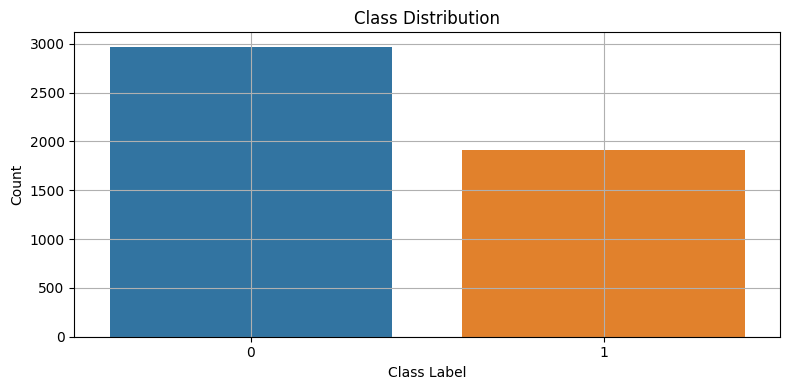

In [5]:
# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Train/Test Split and Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Default and GridSearch Models
grid_params = {
    "SVM (Grid)": {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']},
    "Random Forest (Grid)": {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    "XGBoost (Grid)": {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.01]}
}

all_models = {
    "SVM (Default)": SVC(),
    "SVM (Grid)": GridSearchCV(SVC(), grid_params["SVM (Grid)"], cv=3, scoring='recall', return_train_score=True),

    "Random Forest (Default)": RandomForestClassifier(random_state=42),
    "Random Forest (Grid)": GridSearchCV(RandomForestClassifier(random_state=42), grid_params["Random Forest (Grid)"], cv=3, scoring='recall', return_train_score=True),

    "XGBoost (Default)": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "XGBoost (Grid)": GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), grid_params["XGBoost (Grid)"], cv=3, scoring='recall', return_train_score=True)
}

recalls = {}
falsenegs = {}
train_times = {}
infer_times = {}
grid_results = {}


SVM (Default) Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       594
           1       0.83      0.55      0.66       383

    accuracy                           0.78       977
   macro avg       0.80      0.74      0.75       977
weighted avg       0.79      0.78      0.77       977



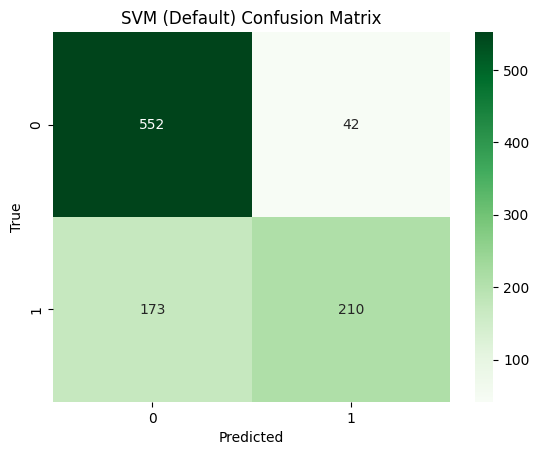


SVM (Grid) Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       594
           1       0.85      0.76      0.80       383

    accuracy                           0.85       977
   macro avg       0.85      0.84      0.84       977
weighted avg       0.85      0.85      0.85       977



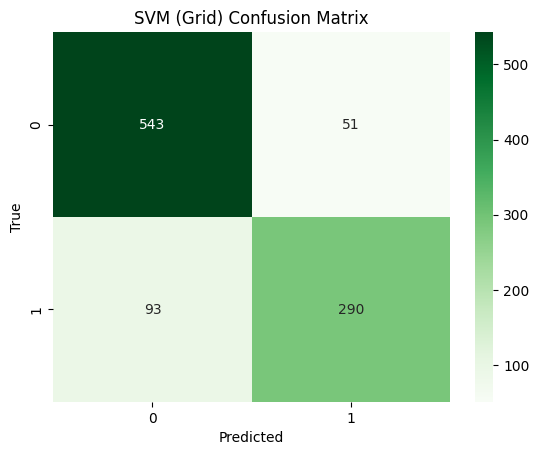


Random Forest (Default) Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       594
           1       0.91      0.61      0.73       383

    accuracy                           0.82       977
   macro avg       0.85      0.78      0.80       977
weighted avg       0.84      0.82      0.81       977



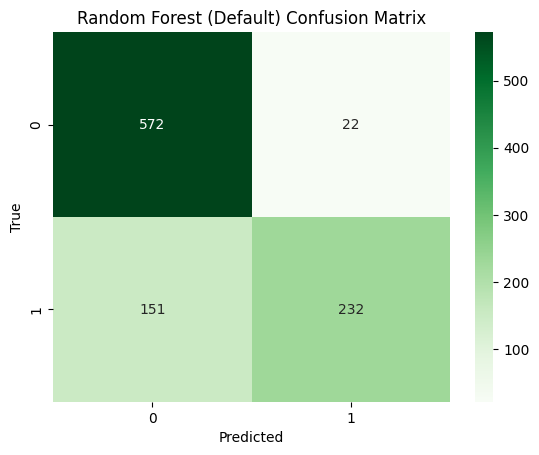


Random Forest (Grid) Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       594
           1       0.91      0.60      0.72       383

    accuracy                           0.82       977
   macro avg       0.85      0.78      0.79       977
weighted avg       0.84      0.82      0.81       977



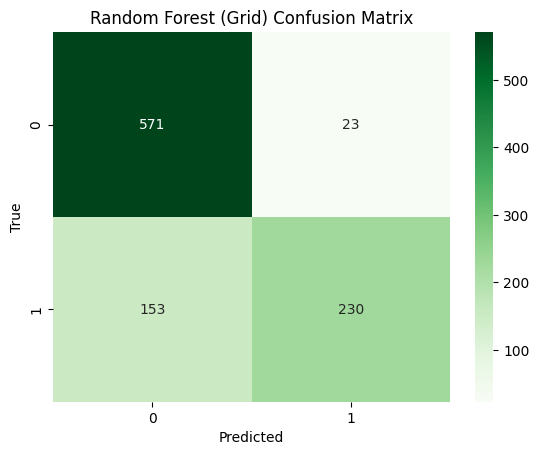


XGBoost (Default) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.89       594
           1       0.89      0.71      0.79       383

    accuracy                           0.85       977
   macro avg       0.86      0.83      0.84       977
weighted avg       0.86      0.85      0.85       977



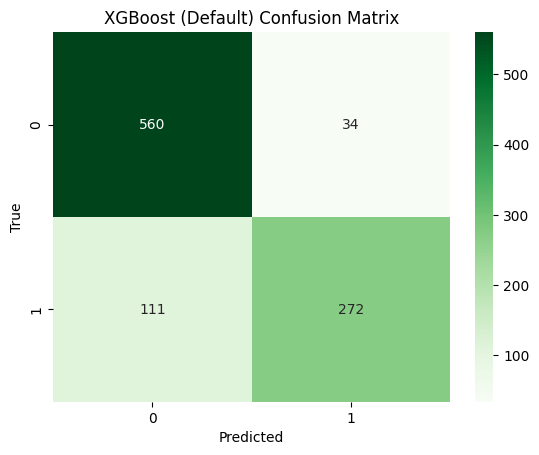


XGBoost (Grid) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       594
           1       0.93      0.71      0.81       383

    accuracy                           0.87       977
   macro avg       0.88      0.84      0.85       977
weighted avg       0.87      0.87      0.86       977



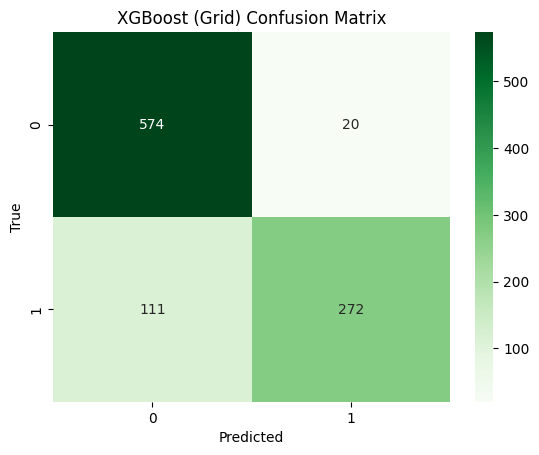

In [8]:
# Training & Evaluation
for name, model in all_models.items():
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    recall = recall_score(y_test, y_pred, pos_label=1)
    fn = cm[1][0]
    tp = cm[1][1]
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    recalls[name] = recall
    falsenegs[name] = fnr
    train_times[name] = end_train - start_train
    infer_times[name] = end_pred - start_pred

    # Grid Search results logging
    if isinstance(model, GridSearchCV):
        df = pd.DataFrame(model.cv_results_)
        df['recall'] = df['mean_test_score']

        # Manually refit for FNR and Accuracy per param combo
        fnr_list = []
        acc_list = []
        for params in df['params']:
            estimator = model.estimator.set_params(**params)
            estimator.fit(X_train, y_train)
            preds = estimator.predict(X_test)
            cm_local = confusion_matrix(y_test, preds)
            fn_local = cm_local[1][0]
            tp_local = cm_local[1][1]
            fnr_local = fn_local / (fn_local + tp_local) if (fn_local + tp_local) > 0 else 0
            acc_local = accuracy_score(y_test, preds)
            fnr_list.append(fnr_local)
            acc_list.append(acc_local)
        df['fnr'] = fnr_list
        df['accuracy'] = acc_list
        grid_results[name] = df.copy()

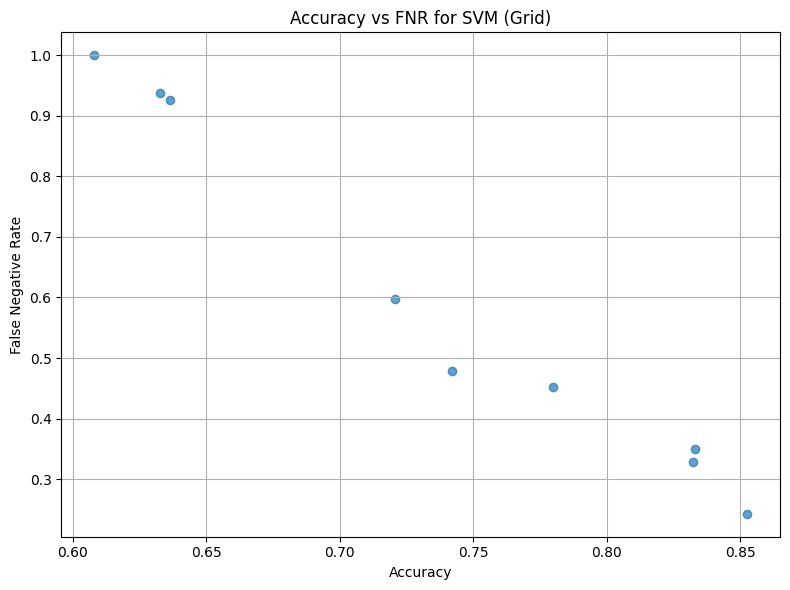

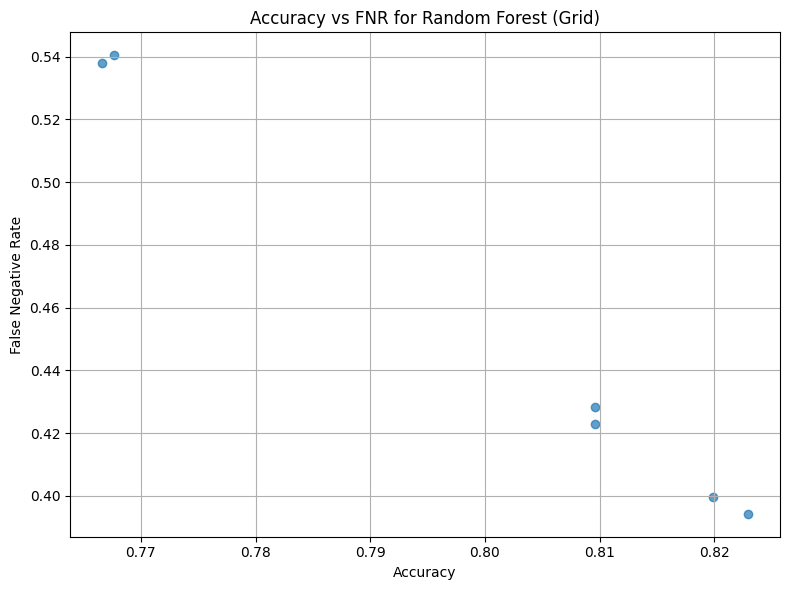

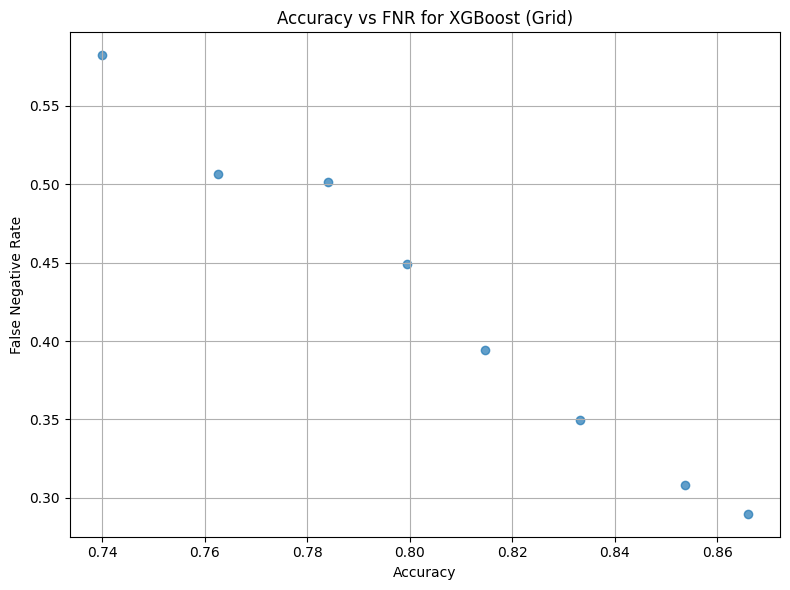

In [9]:
# Scatter plot for hyperparameter combinations
for clf in ["SVM (Grid)", "Random Forest (Grid)", "XGBoost (Grid)"]:
    if clf in grid_results:
        df = grid_results[clf]
        plt.figure(figsize=(8, 6))
        plt.scatter(df['accuracy'], df['fnr'], alpha=0.7)
        plt.title(f"Accuracy vs FNR for {clf}")
        plt.xlabel("Accuracy")
        plt.ylabel("False Negative Rate")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

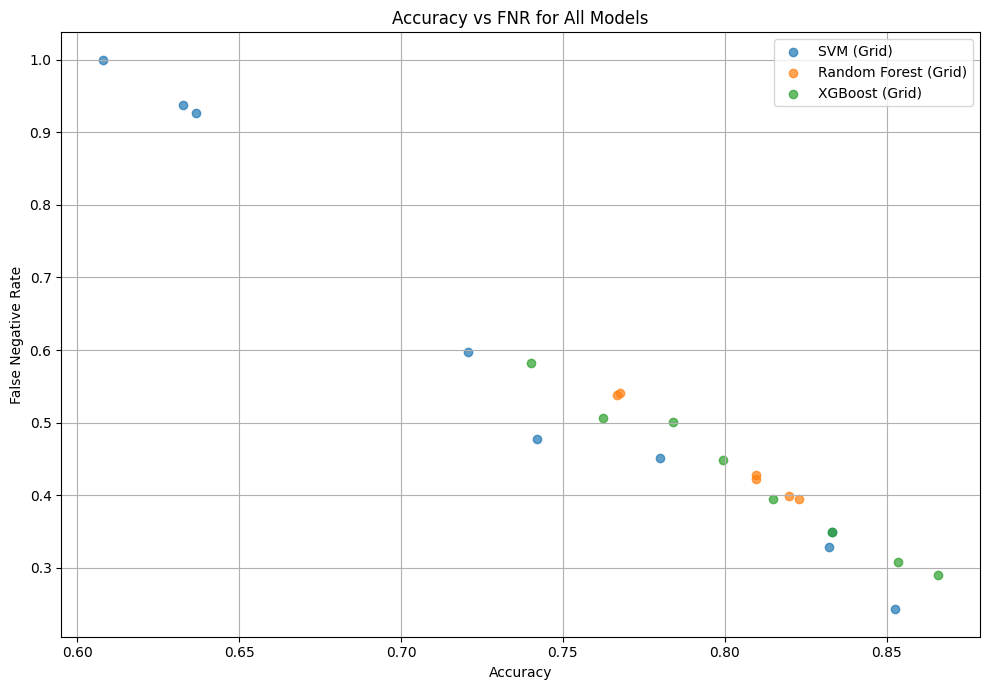

In [10]:
# Combined Scatter plot
plt.figure(figsize=(10, 7))
for clf in ["SVM (Grid)", "Random Forest (Grid)", "XGBoost (Grid)"]:
    if clf in grid_results:
        df = grid_results[clf]
        plt.scatter(df['accuracy'], df['fnr'], label=clf, alpha=0.7)
plt.xlabel("Accuracy")
plt.ylabel("False Negative Rate")
plt.title("Accuracy vs FNR for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Print Training and Inference Times
for model_name in all_models:
    print(f"{model_name}:")
    print(f"  Training Time: {train_times[model_name]:.4f} seconds")
    print(f"  Inference Time: {infer_times[model_name]:.4f} seconds")

SVM (Default):
  Training Time: 27.1962 seconds
  Inference Time: 9.3552 seconds
SVM (Grid):
  Training Time: 1317.6801 seconds
  Inference Time: 10.5679 seconds
Random Forest (Default):
  Training Time: 3.3726 seconds
  Inference Time: 0.0319 seconds
Random Forest (Grid):
  Training Time: 60.9001 seconds
  Inference Time: 0.0618 seconds
XGBoost (Default):
  Training Time: 4.0087 seconds
  Inference Time: 0.0118 seconds
XGBoost (Grid):
  Training Time: 102.3231 seconds
  Inference Time: 0.0114 seconds



False Negative Rates (Abnormal Class):
SVM (Default): 0.4517
SVM (Grid): 0.2428
Random Forest (Default): 0.3943
Random Forest (Grid): 0.3995
XGBoost (Default): 0.2898
XGBoost (Grid): 0.2898


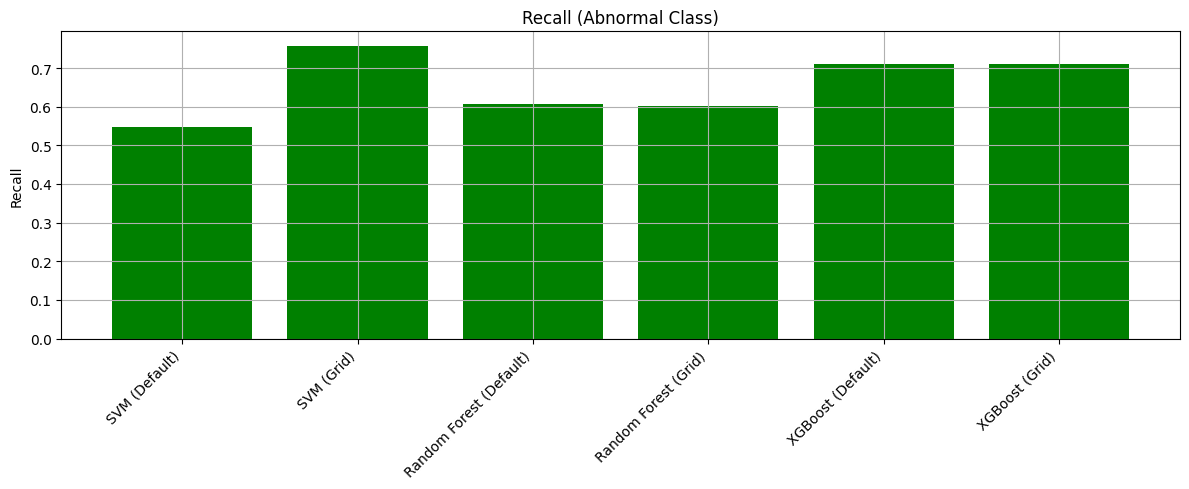

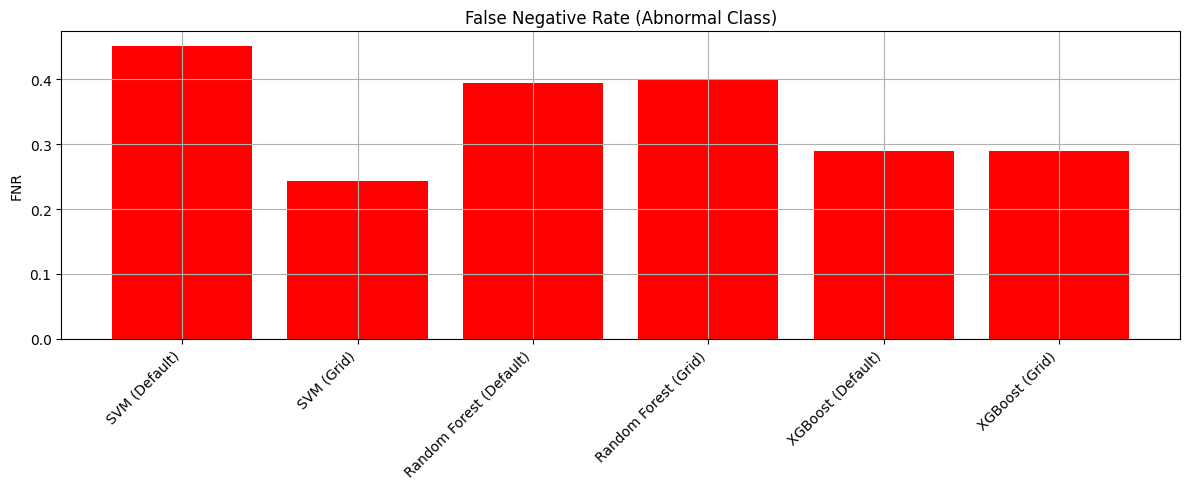

In [12]:
# False Negative Rate Scores
print("\nFalse Negative Rates (Abnormal Class):")
for model_name, fnr in falsenegs.items():
    print(f"{model_name}: {fnr:.4f}")

# Plot Recall and False Negative Rate
plt.figure(figsize=(12, 5))
plt.bar(recalls.keys(), recalls.values(), color='green')
plt.xticks(rotation=45, ha='right')
plt.title("Recall (Abnormal Class)")
plt.ylabel("Recall")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(falsenegs.keys(), falsenegs.values(), color='red')
plt.xticks(rotation=45, ha='right')
plt.title("False Negative Rate (Abnormal Class)")
plt.ylabel("FNR")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
for model_name, model in all_models.items():
    if isinstance(model, GridSearchCV):
        print(f"\n===== {model_name} =====")

        # Total combinations tried
        result_df = grid_results.get(model_name)
        if result_df is None or result_df.empty:
            print("No grid search results found.")
            continue

        print(f" Total Grid Search combinations tried: {len(result_df)}")

        # Best hyperparameters
        print("Best Hyperparameters:")
        print(model.best_params_)

        # Display all combinations sorted by recall
        display_df = result_df[['params', 'accuracy', 'recall']].sort_values(by='recall', ascending=False)
        print("\nAll combinations sorted by Recall:")
        print(display_df.to_markdown(index=False))


===== SVM (Grid) =====
 Total Grid Search combinations tried: 9
Best Hyperparameters:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

All combinations sorted by Recall:
| params                                        |   accuracy |    recall |
|:----------------------------------------------|-----------:|----------:|
| {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}     |   0.85261  | 0.763731  |
| {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  |   0.832139 | 0.682142  |
| {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}      |   0.833163 | 0.680832  |
| {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}   |   0.779939 | 0.552242  |
| {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}    |   0.742068 | 0.528717  |
| {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} |   0.720573 | 0.408623  |
| {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}      |   0.636643 | 0.0731131 |
| {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}       |   0.632549 | 0.0528734 |
| {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}     |   0.607984 | 0         |

===== Ran

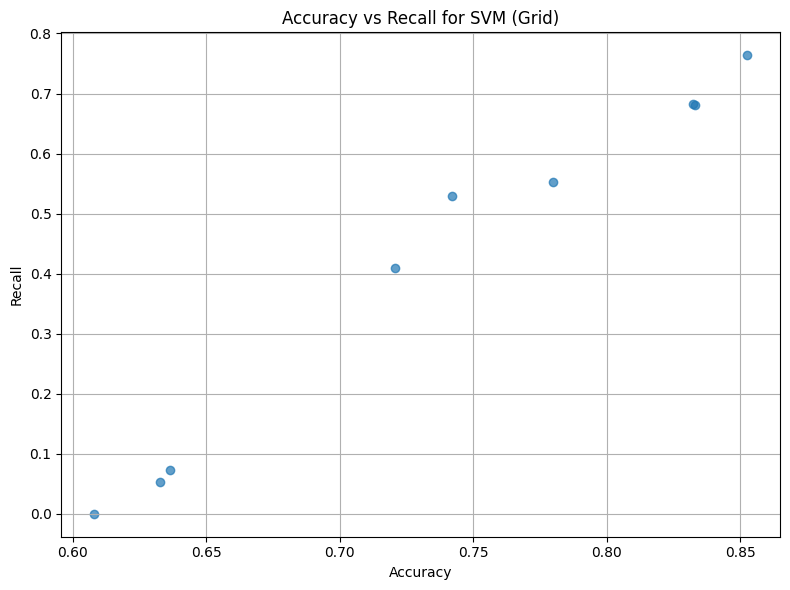

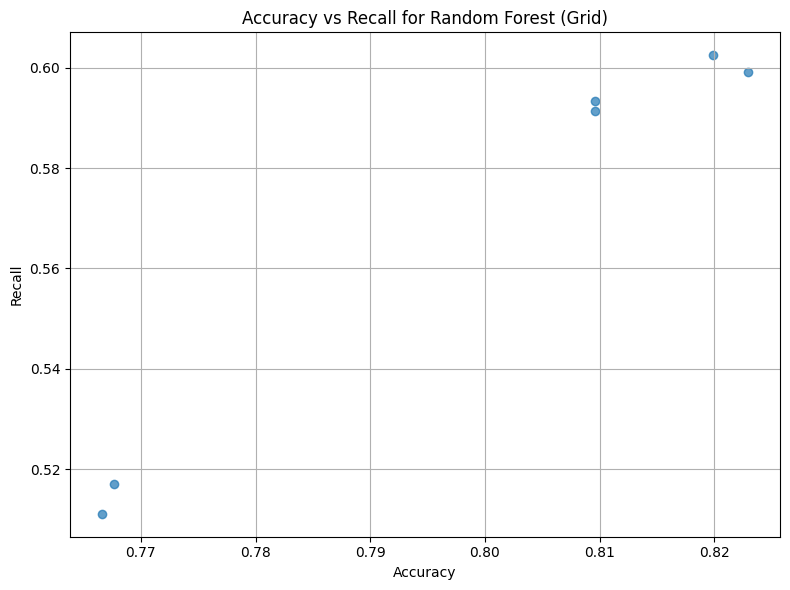

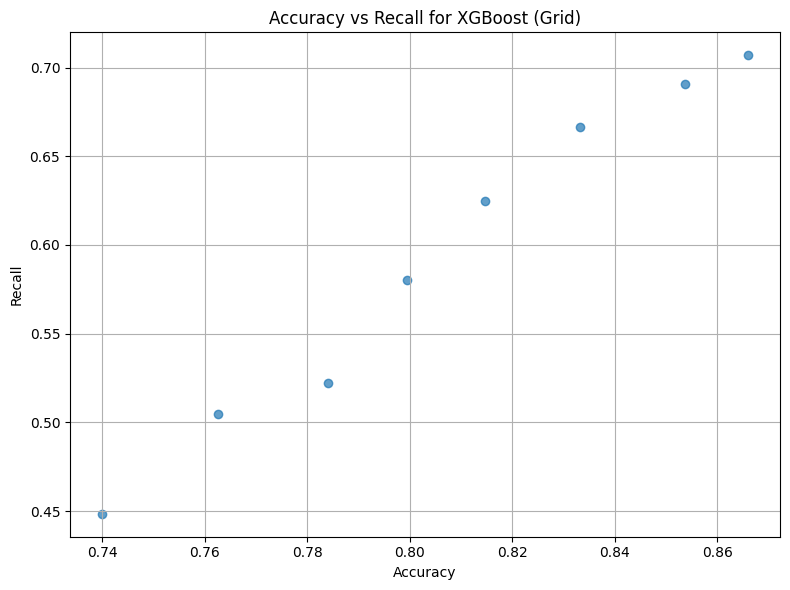

In [14]:
# Scatter plot for hyperparameter combinations
for clf in ["SVM (Grid)", "Random Forest (Grid)", "XGBoost (Grid)"]:
    if clf in grid_results:
        df = grid_results[clf]
        plt.figure(figsize=(8, 6))
        plt.scatter(df['accuracy'], df['recall'], alpha=0.7)
        plt.title(f"Accuracy vs Recall for {clf}")
        plt.xlabel("Accuracy")
        plt.ylabel("Recall")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

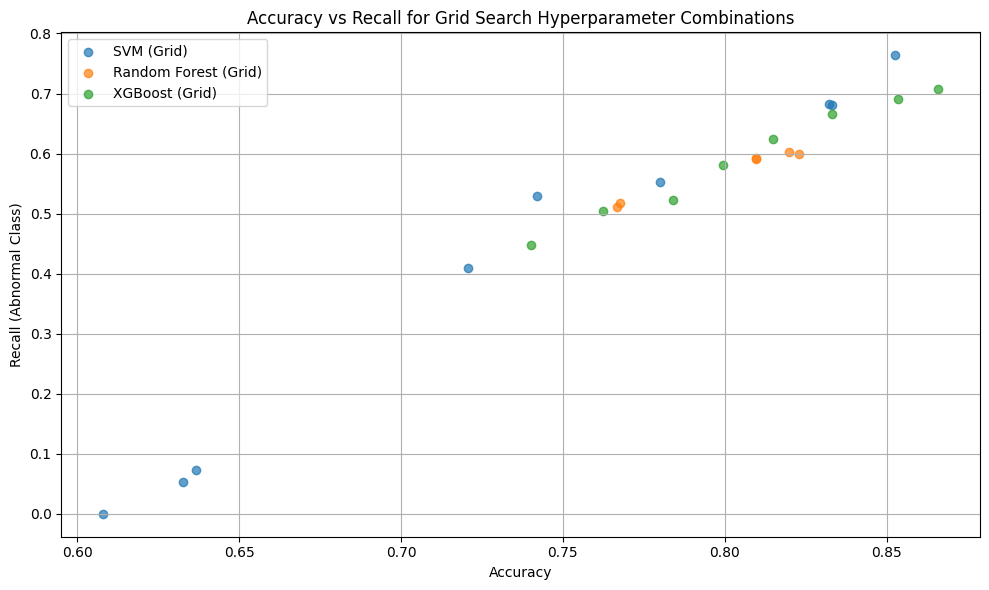

In [15]:
# Scatter Plot: Accuracy vs Recall
plt.figure(figsize=(10, 6))
for model_name, df in grid_results.items():
    plt.scatter(df['accuracy'], df['recall'], label=model_name, alpha=0.7)
plt.xlabel("Accuracy")
plt.ylabel("Recall (Abnormal Class)")
plt.title("Accuracy vs Recall for Grid Search Hyperparameter Combinations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()